Some rows contained invalid data points, uninterpretable. Those we're filtered away with the Regex pattern:

![WcEGigs[1].png](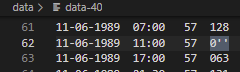)

![hySPjxn[1].png](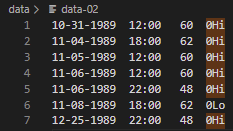)

I filtered these out when reading with the following regex:
([0-9]{2}-[0-9]{2}-[0-9]{4})\t([0-9]{1,2}:[0-9]{2})\t([0-9]{2})\t([0-9]{3})\n

I ommit the date as the it is specified that the value is to be predicted based on time and activity.

I assumed polynomial regression would be the algorithms that fits the best, given the dataset. The datapoints aren't layed out in a way where classification would really make sense.

In [6]:
# data cleaning without date
import os
import re
from datetime import datetime

pattern = re.compile("([0-9]{2}-[0-9]{2}-[0-9]{4})\t([0-9]{1,2}:[0-9]{2})\t([0-9]{2})\t([0-9]{1,3})\n")
taskpattern = re.compile("3[0-5]|4[8]|5[7-9]|6[0-9]|7[0-2]")

x_data = []
y_data = []
errors = 0

files = os.listdir('data')
for f in files:
  with open('data/'+f) as file:
    for line in file:
      try:
        if not pattern.match(line):
          errors += 1
          continue
        date, time, task, value = line.split('\t')
        if not taskpattern.match(task):
          errors += 1
          continue
        h, m = time.split(":")
        h, m = int(h), int(m)
        if h > 23 or h < 0 or m > 59 or m < 0:
          errors += 1
          continue
        t = h*3600+m*60
        newx = [t, int(task)]
        newy = float(value.replace('\n', ''))
        x_data.append(newx)
        y_data.append(newy)
      except:
        errors += 1
        print(f"Bad data: {line}")

print(f"Errors: {errors}")

# split into train and test data
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.26, random_state=6)

Errors: 263


In [2]:
# data cleaning with date
import os
import re
from datetime import datetime

pattern = re.compile("([0-9]{2}-[0-9]{2}-[0-9]{4})\t([0-9]{1,2}:[0-9]{2})\t([0-9]{2})\t([0-9]{1,3})\n")
taskpattern = re.compile("3[0-5]|4[8]|5[7-9]|6[0-9]|7[0-2]")

x_data = []
y_data = []
errors = 0

files = os.listdir('data')
for f in files:
  with open('data/'+f) as file:
    for line in file:
      try:
        if not pattern.match(line):
          errors += 1
          continue
        date, time, task, value = line.split('\t')
        if not taskpattern.match(task):
          errors += 1
          continue
        dtstr = date+" "+time+":00"
        dt = datetime.strptime(dtstr, '%m-%d-%Y %H:%M:%S')
        newx = [dt.timestamp(), int(task)]
        newy = float(value.replace('\n', ''))
        x_data.append(newx)
        y_data.append(newy)
      except:
        errors += 1
        print(f"Bad data: {line}")

print(f"Errors: {errors}")

# split into train and test data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=1)

Bad data: 04-09-1991	56:35	58	237

Bad data: 04-09-1991	56:35	33	016

Bad data: 04-09-1991	56:35	34	040

Bad data: 06-31-1991	07:50	58	149

Bad data: 06-31-1991	07:50	33	004

Bad data: 06-31-1991	07:50	34	024

Bad data: 06-31-1991	13:30	60	162

Bad data: 06-31-1991	13:30	33	005

Bad data: 06-31-1991	19:45	62	213

Bad data: 06-31-1991	19:45	33	011

Errors: 270


Here we find some dates that are not valid eg. 31st of June. However, I do base the results below on the data without the dates as I later motivate why I believe having the date in the model is redundant.

In [7]:
# linear regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

reg = linear_model.LinearRegression()
reg.fit(x_train, y_train)
reg.score(x_test, y_test)

0.41462803769484236

In [8]:
# polynomial regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

maxDegree = 1
maxScore = 0

for x in range(1, 8):
  poly = PolynomialFeatures(degree=x)
  px_train = poly.fit_transform(x_train)
  px_test = poly.fit_transform(x_test)

  reg = linear_model.LinearRegression()
  reg.fit(px_train, y_train)
  score = reg.score(px_test, y_test)

  if score > maxScore:
    maxScore = score
    maxDegree = x

print(f"{maxDegree}: {maxScore}")

3: 0.6241498493652502


In [9]:
# random forest regression
from sklearn.ensemble import RandomForestRegressor

maxScore = 0
maxDepth = 1
maxEstimators = 1

for x in range(1, 14):
  for y in range(1, 60):
    regr = RandomForestRegressor(max_depth=x, n_estimators=y, random_state=0)
    regr.fit(x_train, y_train)
    score = regr.score(x_test, y_test)
    if score > maxScore:
      maxScore = score
      maxDepth = x
      maxEstimators = y

print(f"{maxDepth}: {maxScore}")

7: 0.66190276654815


As we see here random forest regression with max_depth of 10 yields the highest possible score.

In [10]:
# knn
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=6)
neigh.fit(x_train, y_train)
neigh.score(x_test, y_test)

0.1462026991267531

In [11]:
# svm
from sklearn import svm
clf = svm.SVC()
clf.fit(x_train, y_train)
clf.score(x_test, y_test)

0.09354326541413072

SVM was by far the slowest algorithms to compute. It also yielded the lowest scores of all the classification and regression algorithms.

In [12]:
# decision tree
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)
clf.score(x_test, y_test)

0.20468377877745436

In [13]:
# random forest classifier
from sklearn.ensemble import RandomForestClassifier

maxDepth = 1
maxScore = 0
maxEstimators = 1

for x in range(1, 5):
  for y in range(1, 60):
    clf = RandomForestClassifier(max_depth=x, n_estimators=y, random_state=0)
    clf.fit(x_train, y_train)
    score = clf.score(x_test, y_test)
    if score > maxScore:
      maxScore = score
      maxDepth = x
      maxEstimators = y

print(f"{maxDepth}: {maxScore}")

4: 0.15242127546970097


As we see here, all the tested classification algorithms above yeilded low scores (except for Random Forest Classification), SVM yielding the lowest of all algorithms tried out.

With that said, the data cleaning could be refined if the context of the datasets are more understood because there are a lot of datapoints which don't really seem valid. Eg. there are many which record a glucose value of 0 which is not really humanly possible while still staying alive. Such recordings could be faulty.

I decided to ommit the date from the actual model training results, and my reasoning is it is not relevant when predicting the glucose value because it is unlikely the typical glucose value highly varies between the years 1991 and 2022.

From an ethical standpoint, this model should absolutely not be used in the real world. Not only is the data that this model is trained with not well understood but in my opinion the prediction is a gross estimate based just on the time of day it is and the vague activity by code that was done before.